<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word2vec">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View original Word2Vec tutorial on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/word2vec_on_eventlog.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run this notebook in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Grrtzm/word2vec/blob/main/word2vec_on_eventlog.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word2vec.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download original Word2Vec tutorial notebook</a>
  </td>
</table>

# Word2Vec

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
import time

import io
import re
import string
import tensorflow as tf
import tqdm
import sys    # tbv sys.exit()

tf.get_logger().setLevel('INFO')

from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Set the number of negative samples per positive context.
# Key point: num_ns (number of negative samples per positive context word) 
# between [5, 20] is shown to work best for smaller datasets, while num_ns between [2,5] suffices for larger datasets.
num_ns = 5
window_size = 10
embedding_dim = 128 # Dimension of the dense embedding.
vocab_size = 20000 # Grootte van het woordenboek. Deze mag best groot zijn. Standaard (uit demo): 4096
sequence_length = 40 # 10 # Aantal woorden in een zin.
epochs = 500 #10 # Number of training epochs for Word2Vec

### Helper function to generate training data

Generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) 
based on window size, number of negative samples and vocabulary size.

In [2]:
## Gert 2021024 LogEvent2Vec gebruikt CBOW model, hier worden skip-grams gebruikt (zie LogEvent2Vec pdf pagina 9, paragraaf 4.2.1) 
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)    # Gert 20210806 Deze uitgezet omdat er geen overbodige woorden zijn in de vocabulaire

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,       # Gert 20210806 Deze uitgezet omdat er geen overbodige woorden zijn in de vocabulaire
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=SEED,
                name="negative_sampling")

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

### Prepare training data for Word2Vec

In [3]:
# events.csv from my google drive
!gdown --id 1BtebwjRKsKNyD1fvmqNGnh-Bfd0Z9R99

path_to_file = "./events.csv"
print(f"File containing log events: {path_to_file}")
print()

# Read text from the file and take a look at the first few lines.
numlines = 5
print(f"First {numlines} lines from the logfile:")
count = 1
with open(path_to_file) as f:
    lines = f.read().splitlines()
    for line in lines[:numlines]:
        print(f"Line #{count}")
        print(line)
        print()
        count = count + 1

print()

# Use the non empty lines to construct a tf.data.TextLineDataset object for next steps.
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

# Vectorize sentences from the corpus

# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
    '[%s]' % re.escape(string.punctuation), '')

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size, # None
    output_mode='int',
    output_sequence_length=sequence_length)

# Call adapt on the text dataset to create vocabulary.
vectorize_layer.adapt(text_ds.batch(1024))
print("Vocabulaire: ", end = "")

# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
#inverse_vocab.remove('[UNK]') # Ja, dit is dus symptoom bestrijding. Die [UNK] moet ik dus eigenlijk uit de vectorize_layer halen, maar dat lukt me niet.
print(inverse_vocab[:20])
print()

print(f"Number of words in vocabulary (limit is {vocab_size}): {len(vectorize_layer.get_vocabulary())-1}")

# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

# Obtain number of sequences from the dataset
sequences = list(text_vector_ds.as_numpy_iterator())
print("Number of lines = ",end="")
print(len(sequences))
print()

# Take a look at few examples from sequences.
print("5 examples from sequences:")
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")
    print()
time.sleep(0.1) # Nodig om tekst op de juiste plaats terecht te laten komen (i.v.m. multi-threading)


File containing log events: D:\logs\events.csv

First 5 lines from the logfile:
Line #1
Securi_4624InformationMicrosoft-Windows-Security-Auditing Securi_4672InformationMicrosoft-Windows-Security-Auditing Securi_4624InformationMicrosoft-Windows-Security-Auditing Securi_4672InformationMicrosoft-Windows-Security-Auditing Securi_4624InformationMicrosoft-Windows-Security-Auditing Securi_4672InformationMicrosoft-Windows-Security-Auditing System_6InformationMicrosoft-Windows-FilterManager System_6013InformationEventLog System_6005InformationEventLog System_6009InformationEventLog System_6InformationMicrosoft-Windows-FilterManager Securi_4624InformationMicrosoft-Windows-Security-Auditing Securi_4672InformationMicrosoft-Windows-Security-Auditing System_6InformationMicrosoft-Windows-FilterManager System_1InformationMicrosoft-Windows-FilterManager System_6InformationMicrosoft-Windows-FilterManager Securi_4624InformationMicrosoft-Windows-Security-Auditing Securi_4672InformationMicrosoft-Windows-Se

### Generate training examples from sequences
`sequences` is now a list of int encoded sentences.

In [4]:
# Model and Training
print(f"Genererate training examples from sequences, using: window_size={window_size}, num_ns={num_ns}, vocab_size={vocab_size}, seed={SEED}")
time.sleep(1) # Nodig om tekst op de juiste plaats terecht te laten komen (i.v.m. multi-threading)
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=window_size,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)
time.sleep(1) # Nodig om tekst op de juiste plaats terecht te laten komen (i.v.m. multi-threading)
print(f"Number of training examples; targets:{len(targets)}, contexts:{len(contexts)}, labels:{len(labels)}")

# Configure the dataset for performance
#BATCH_SIZE = 1024 # Als deze te groot wordt, dan crasht het script.
#BATCH_SIZE = 52 # Deze moet net zo groot zijn als het aantal targets/contexts/labels
BATCH_SIZE = len(targets)
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Add cache() and prefetch() to improve performance.
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Genererate training examples from sequences, using: window_size=10, num_ns=5, vocab_size=20000, seed=42


100%|██████████| 909/909 [00:03<00:00, 264.49it/s]


Number of training examples; targets:8197, contexts:8197, labels:8197


### Model and Training

In [5]:
previous_accuracy = 0
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global previous_accuracy
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
        #if(logs.get('accuracy') < previous_accuracy):
        #    print("\nAccuracy decreased so cancelling training!")
        #    self.model.stop_training = True
        previous_accuracy = logs.get('accuracy')

callbacks = myCallback()

class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)
        self.dots = Dot(axes=(3, 2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        
        return self.flatten(dots)

# Define loss function and compile model
#embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# Train the model with dataset prepared above for some number of epochs.
print("Trainen van Word2Vec:")
# word2vec.fit(dataset, epochs=epochs, callbacks=[tensorboard_callback])
history = word2vec.fit(dataset, epochs=epochs, callbacks=[callbacks])
print()

# Embedding lookup and analysis
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

# Create and save the vectors and metadata file
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index < 1:
        continue  # skip 0, it's padding
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# Download the vectors.tsv and metadata.tsv to analyze the obtained embeddings in the Embedding Projector.

Trainen van Word2Vec:
Epoch 1/500
1/1 [==============================] - 1s 917ms/step - loss: 1.7903 - accuracy: 0.1940
Epoch 2/500
1/1 [==============================] - 0s 22ms/step - loss: 1.7877 - accuracy: 0.3185
Epoch 3/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7850 - accuracy: 0.4149
Epoch 4/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7822 - accuracy: 0.5013
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7794 - accuracy: 0.5529
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7765 - accuracy: 0.5967
Epoch 7/500
1/1 [==============================] - 0s 22ms/step - loss: 1.7736 - accuracy: 0.6313
Epoch 8/500
1/1 [==============================] - 0s 22ms/step - loss: 1.7706 - accuracy: 0.6639
Epoch 9/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7674 - accuracy: 0.6918
Epoch 10/500
1/1 [==============================] - 0s 23ms/step - loss: 1.7642 - accuracy: 0.7

<Figure size 432x288 with 0 Axes>

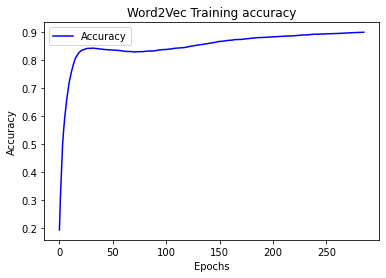

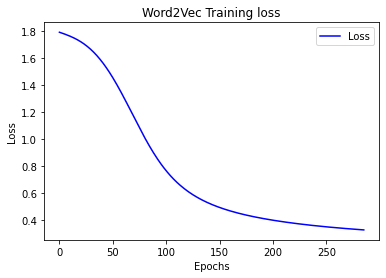

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
loss=history.history['loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'b')
plt.title('Word2Vec Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])
plt.figure()

plt.plot(epochs, loss, 'b')
plt.title('Word2Vec Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

Download the `vectors.tsv` and `metadata.tsv` to analyze the obtained embeddings in the [Embedding Projector](https://projector.tensorflow.org/).

In [7]:
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass